In [1]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from einops import rearrange
from gluonts.dataset.pandas import PandasDataset, is_uniform, infer_freq
from gluonts.dataset.split import split
from uni2ts.model.moirai import MoiraiForecast, MoiraiModule
from uni2ts.eval_util.plot import plot_single, plot_next_multi

from mov_av import moving_average

In [2]:
it_data_23_24 = pd.read_csv('data/it_load_data_23_24.csv', delimiter=',')
it_data_23_24['DateUTC'] = pd.to_datetime(it_data_23_24['DateUTC'])
it_data_23_24 = it_data_23_24.set_index('DateUTC')

In [3]:
SZ = 'small'
PDT = 7 * 24  # prediction length: any positive integer
CTX = 1 * ((4 * PDT) + 48)  # context length: any positive integer
PSZ = 64  # patch size: choose from {"auto", 8, 16, 32, 64, 128}
BSZ = 24  # batch size: any positive integer
TEST = 6 * ((4 * PDT) + 48) # test set length: any positive integer

HISTORY = CTX
NUM_WINDOWS = TEST // PDT
DIST = PDT

In [4]:
def get_model_data(model_folder: str, num_of_weeks: int, data: pd.DataFrame):
    model_folder = model_folder + str(num_of_weeks)
    model = os.listdir(model_folder)[0]

    model_path = os.path.join(model_folder, model)

    fine_tuned_model = MoiraiForecast.load_from_checkpoint(
        prediction_length=PDT,
        context_length=CTX,
        patch_size=PSZ,
        num_samples=100,
        target_dim=1,
        feat_dynamic_real_dim=0,
        past_feat_dynamic_real_dim=0,
        checkpoint_path=model_path
    )

    ds = PandasDataset(data, target='Value', freq='H')

    # Split into train/test set
    train, test_template = split(
        ds, offset=-(data.shape[0] - num_of_weeks*(7*24))
    )  # assign last TEST time steps as test set

    # Construct rolling window evaluation
    test_data = test_template.generate_instances(
        prediction_length=PDT,  # number of time steps for each prediction
        windows=NUM_WINDOWS,  # number of windows in rolling window evaluation
        distance=DIST, # number of time steps between each window - distance=PDT for non-overlapping windows
        max_history=HISTORY
    )

    return fine_tuned_model, test_data

In [14]:
model_folder = "outputs/finetune/moirai_small/2nd_run/checkpoints/it_load_data_train_"
num_of_weeks = 6
data = it_data_23_24

model, test_data = get_model_data(model_folder, num_of_weeks, data)

In [15]:
predictor = model.create_predictor(batch_size=BSZ)
forecasts = predictor.predict(test_data.input)

input_it = iter(test_data.input)
label_it = iter(test_data.label)
forecast_it = iter(forecasts)

In [16]:
errors = []
for i in range(NUM_WINDOWS):
    try:
        forecast = next(forecast_it).mean
    except:
        break
    
    target = data.iloc[CTX+(i*DIST) : CTX+(i*DIST)+PDT, :].values.reshape(-1)

    errors.append(np.mean(np.abs(target-forecast)))

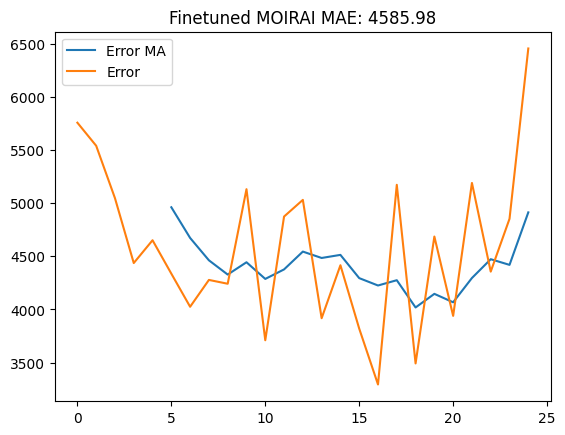

In [17]:
window_size = 6
plt.title(f"Finetuned MOIRAI MAE: {np.round(np.mean(finetuned_errors), 2)}")
plt.plot(range(window_size-1,len(errors)), moving_average(np.array(finetuned_errors), window_size), label='Error MA')
plt.plot(range(len(finetuned_errors)), finetuned_errors, label='Error')
plt.legend()
# plt.savefig("finetuned_moirai_mae.png");